Calculate the light curves of TNO occultations based on object size, distance, and apparent stellar size

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [12]:
# Load csv file with LUT. Create numpy interpolator
lut_array = np.loadtxt('occultation_intensity_lut.csv', delimiter=',', skiprows=1)
interpolator = scipy.interpolate.CloughTocher2DInterpolator(lut_array[:, :2], lut_array[:, 2])

In [24]:
# Per Eqs. 12 in Rocques & Moncuquet 2000
def intensity_with_stellar_disk(r, R_TNO, R_star, n_steps=50):
    '''Intensity profile for a TNO occultation of a star with projected radius R_star.

    Parameters:
    ----------
    r : float
        Distance from the center of the shadow in Fresnel units.
    R_TNO : float
        Radius of the TNO in Fresnel units.
    R_star : float
        Projected radius of the star at the TNO distance, in Fresnel units.
    n_steps : int (default 50)
        Number of steps to use in each variable of the 2D numerical integration.
    '''
    if R_star == 0:
        return interpolator(r, R_TNO)
    s_vals = np.linspace(0, R_star, n_steps)
    theta_vals = np.linspace(0, np.pi, n_steps)
    distance_vals = np.zeros(n_steps ** 2)
    s_vals_long = np.zeros(n_steps ** 2)
    for i in range(n_steps):
        for j in range(n_steps):
            s = s_vals[i]
            theta = theta_vals[j]
            distance = np.sqrt(r**2 + s**2 + 2 * r * s * np.cos(theta))
            distance_vals[i * n_steps + j] = distance
            s_vals_long[i * n_steps + j] = s
    grid_x, grid_y = np.meshgrid(distance_vals, R_TNO)
    integrand_vals = interpolator((grid_x, grid_y))
    integral_result = np.sum(integrand_vals * s_vals_long)
    normalization_factor = (2 / (np.pi * R_star**2)) * (np.pi / n_steps) * (R_star / n_steps)
    return normalization_factor * integral_result

# Compute intensity profiles for various TNO and projected star radii
r_list = np.linspace(0, 15, 250)
r_star_list = [0.1, 1, 5]
r_tno_list = [0.1, 1, 10]
intensities = np.zeros((len(r_tno_list), len(r_star_list), len(r_list)))
for i, r_tno in enumerate(r_tno_list):
    for j, r_star in enumerate(r_star_list):
        for k, r in enumerate(r_list):
            intensities[i, j, k] = intensity_with_stellar_disk(r, r_tno, r_star)

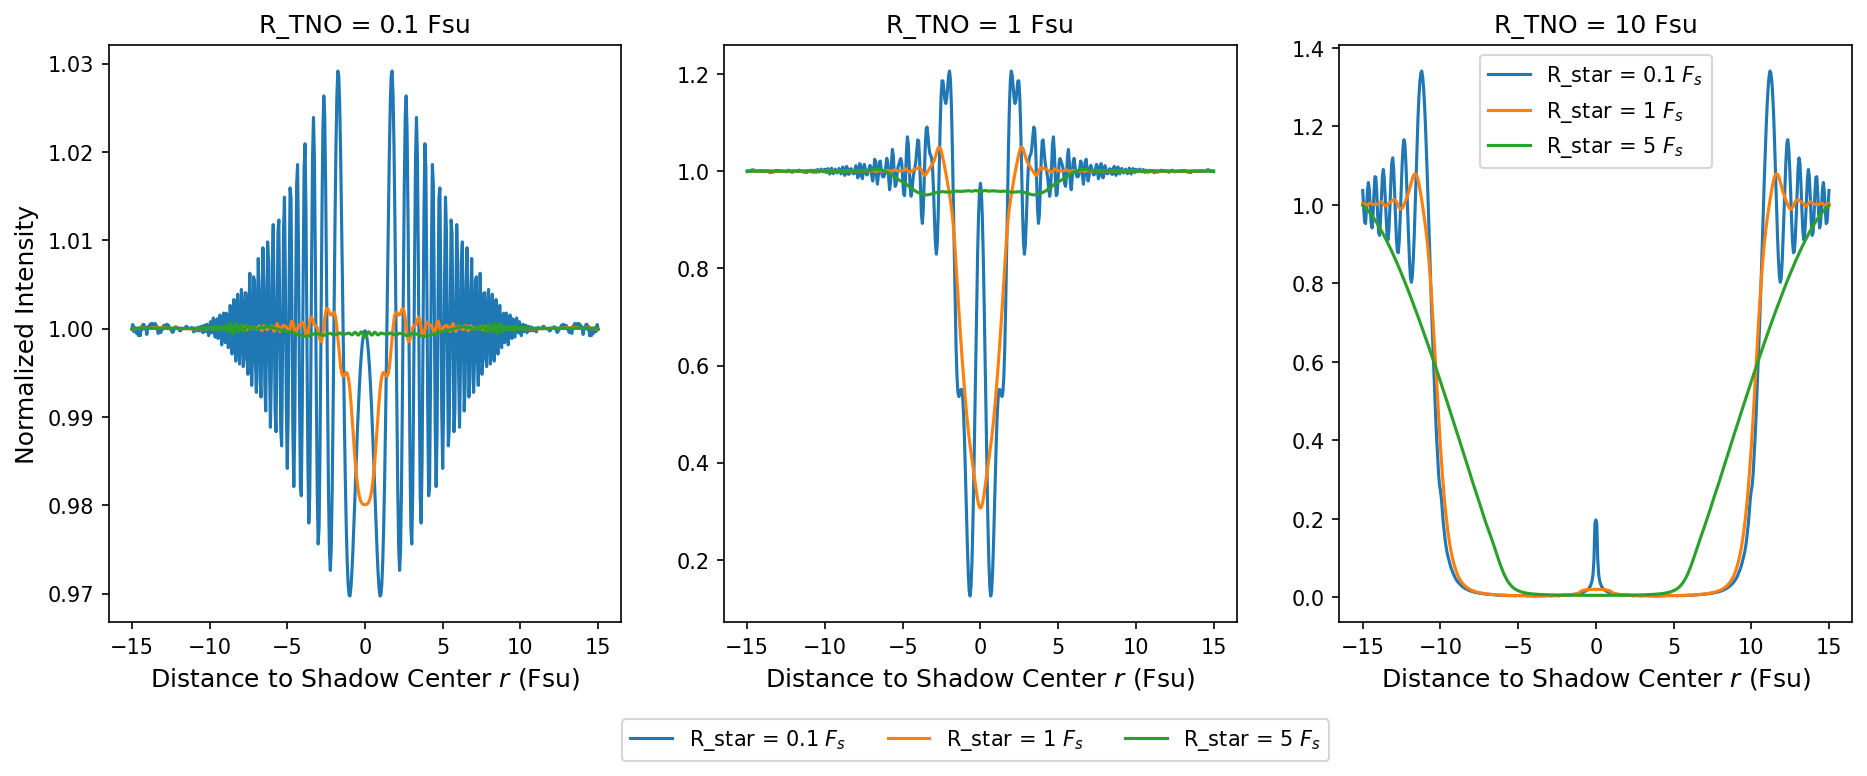

In [25]:
# Create three axes, each with a different r_tno and plotting the intensity profiles for all 5 r_star values
%matplotlib inline
# set dpi 200
plt.rcParams['figure.dpi'] = 150
# Make all axis labels and grid labels
plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    for j in range(3):
        r_list_both = np.concatenate((-r_list[::-1], r_list))
        intensities_both = np.concatenate((intensities[i, j][::-1], intensities[i, j]))
        ax[i].plot(r_list_both, intensities_both, label=f"R_star = {r_star_list[j]}" + r' $F_s$')
    ax[i].set_xlabel(r'Distance to Shadow Center $r$ (Fsu)')
    ax[i].set_title(f'R_TNO = {r_tno_list[i]} Fsu')

ax[0].legend( bbox_to_anchor=(2.4, -0.15), ncol=3)
ax[0].set_ylabel('Normalized Intensity')
plt.legend()
plt.show()

In [26]:
def tno_occult_lightcurve(r_TNO, theta_star, d_TNO=40, wavelength=500,
                          omega=0, y=0, sampling_rate=10, n_steps=50,
                          smoothing_points=10):
    '''Create a synthetic light curve for a TNO occultation of a star.
    
    Parameters:
    ----------
    R_TNO : float
        Radius of the TNO in km.
    theta_star : float
        Angular radius of the star, in milliarcesconds.
    d_TNO : float (default 40)
        Distance from the Earth to the TNO in AU.
    wavelength : float (default 500)
        Wavelength of observation in nm.
    omega : float (default 0)
        Angle between solar opposition and the TNO line of sight, in degrees.
    y : float (default 0)
        Minimum distance from the star line of sight to the TNO center, in km.
    sampling_rate : int (default 10)
        Temporal sampling rate of the light curve, in Hz.
    n_steps : int (default 50)

    Returns:
    ---------
    result_dict : dict
        Dictionary with the following keys:
        - r_star_fsu : float
            Projected radius of the star at the TNO distance, in Fresnel units.
        - r_tno_fsu : float
            Radius of the TNO in Fresnel units.
        - y_fsu : float
            Minimum distance from the star line of sight to the TNO center, in Fresnel units.
        - times : array
            Array of times in seconds.
        - r_points : array
            Array of distances from the shadow center in Fresnel units.
        - intensities : array
            Array of normalized intensities at each time point.
    '''

    # Calculate Fresnel scale, in km
    fsu = np.sqrt(wavelength * 1e-12 * d_TNO * 1.496e8 / 2)
    # Convert TNO and star sizes to Fresnel scale units
    R_TNO_fsu = r_TNO / fsu
    R_star_fsu = theta_star / 1000 / 3600 / 180 * np.pi * d_TNO * 1.496e8 / fsu
    y_fsu = y / fsu
    if R_star_fsu + np.sqrt(y_fsu **2 + R_TNO_fsu ** 2) > 15:
        raise ValueError("System size too large--keep it under 15 Fsu.")

    # Calculate the velocity of the TNO in the sky plane, in fsu/s
    v_earth = 29.8 / fsu
    v_object = v_earth * (np.cos(omega * np.pi / 180) - np.sqrt(1 / d_TNO))
    # Time it takes for r to go from -15 to 15 fsu
    duration = 30 / v_object
    t_spacing = 1 / sampling_rate
    t_points = np.arange(0, duration, t_spacing)
    x_points = -15 + v_object * t_points
    r_points = np.sqrt(x_points**2 + y_fsu**2)
    intensity_points = np.zeros_like(t_points)
    for i, t in enumerate(t_points):
        t_subpoints = np.linspace(t - t_spacing / 2, t + t_spacing / 2, smoothing_points)
        x_subpoints = -15 + v_object * t_subpoints
        r_subpoints = np.sqrt(x_subpoints**2 + y_fsu**2)
        for j in range(smoothing_points):
            intensity_points[i] += intensity_with_stellar_disk(r_subpoints[j], R_TNO_fsu, R_star_fsu, n_steps=n_steps)
        intensity_points[i] /= smoothing_points
    result_dict = {'r_star_fsu': R_star_fsu, 'r_tno_fsu': R_TNO_fsu, 'y_fsu': y_fsu, 'times': t_points,
                   'r_points': r_points, 'intensities': intensity_points}
    return result_dict


0.7978836279039113 2.025415169808539 0.0


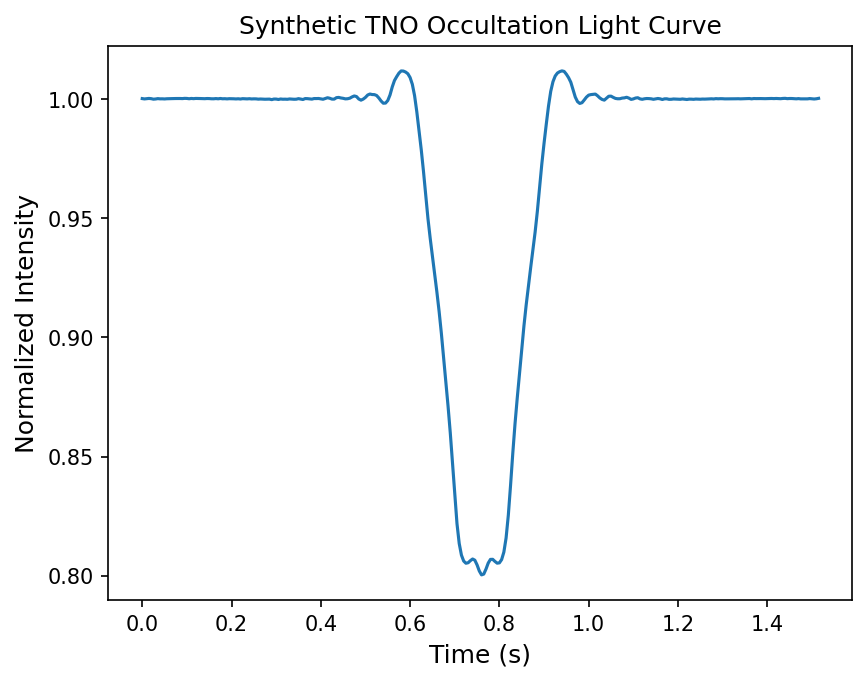

In [30]:
lightcurve_dict = tno_occult_lightcurve(r_TNO=1, theta_star=0.1, d_TNO=35, omega=0, wavelength=600, y=0, sampling_rate=200, n_steps=50, smoothing_points=1)
print(lightcurve_dict['r_tno_fsu'], lightcurve_dict['r_star_fsu'], lightcurve_dict['y_fsu'])
plt.plot(lightcurve_dict['times'], lightcurve_dict['intensities'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Intensity')
plt.title('Synthetic TNO Occultation Light Curve')
plt.show()